# TF-Hub CORD-19 Swivel Embeddings

**Acknowledgements:**
1. TensorFlow Hub [Colab Notebook](https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras).  
2. TensorFlow Github [Notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb).  
3. Swivel text [embeddings](https://tfhub.dev/tensorflow/cord-19/swivel-128d/3).  

In [1]:
embedding_url = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'

**Table of contents:**
1. [Setup](#Setup)  
2. [Analyze embeddings](#Analyze-embeddings)  
3. [SciCite: Citation intent classification](#SciCite:-Citation-intent-classification)  
4. [Training a citation intent classifier](#Training-a-citation-intent-classifier)  
5. [Train and evaluate the model](#Train-and-evaluate-the-model)  
6. [Evaluate the model](#Evaluate-the-model)  

## Setup

In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

## Analyze embeddings

Calculate and plot the correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together.

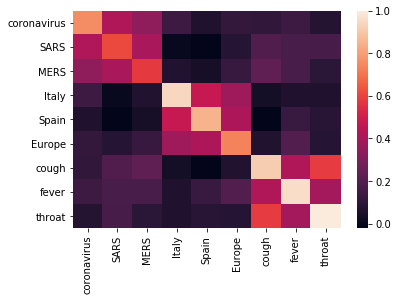

In [3]:
# Use the inner product between 2 vectors as a similarity measure
def plot_correlation(labels, features):
    corr = np.inner(features, features)  # similarity measure
    corr /= np.max(corr)
    sns.heatmap(corr, xticklabels=labels, yticklabels=labels)
    
# Generate embeddings for some terms
queries = [
    # Related viruses
    'coronavirus', 'SARS', 'MERS',
    # Regions
    'Italy', 'Spain', 'Europe', 
    # Symptoms
    'cough', 'fever', 'throat'
]

module = hub.load(embedding_url)
embeddings = module(queries)

plot_correlation(queries, embeddings)

The heatmap shows that the embedding has successfully captured the meaning of similar terms.

## SciCite: Citation intent classification

Use the embedding for downstream tasks.

Use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) to classify citation intents in academic papers. Given a sentence with a citation from a paper, classify whether the main intent of the citation is as background information (`background`), use of methods (`method`), or comparing results (`result`).

In [5]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

/home/ivogeorg/anaconda3/envs/tf-2/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3-us-west-2.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/scicite/1.0.0.incompleteD0IF7R/scicite-train.tfrecord


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/scicite/1.0.0.incompleteD0IF7R/scicite-validation.tfrecord


Shuffling and writing examples to /home/ivogeorg/tensorflow_datasets/scicite/1.0.0.incompleteD0IF7R/scicite-test.tfrecord


Dataset scicite downloaded and prepared to /home/ivogeorg/tensorflow_datasets/scicite/1.0.0. Subsequent calls will reuse this data.


#### InsecureRequestWarning
```
/home/ivogeorg/anaconda3/envs/tf-2/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3-us-west-2.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
```

In [6]:
#@title A few labeled examples from the training set
NUM_EXAMPLES = 10#@param {type:'integer'}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]  # TODO: ?
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
    m = builder.info.features[LABEL_NAME].names
    return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))

pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],  # TODO: ?
    LABEL_NAME: [label2str(x) for x in data[1]]
})

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


## Training a citation intent classifier

Train a Keras classifier on the SciCite dataset, using the CORD-19 embeddings with a classification layer on top.

In [7]:
EMBEDDING = embedding_url
TRAINABLE_MODULE = False  #@param {type: 'boolean'}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[],  # TODO: hub.KerasLayer
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               17301632  
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 17,302,019
Trainable params: 387
Non-trainable params: 17,301,632
_________________________________________________________________


#### WARNING
```
WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.
```

## Train and evaluate the model

In [8]:
EPOCHS = 35#@param {type: 'integer'}
BATCH_SIZE = 32#@param {type: 'integer'}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35
257/257 [==============================] - 2s 8ms/step - loss: 0.9520 - accuracy: 0.5466 - val_loss: 0.8029 - val_accuracy: 0.6528
Epoch 2/35
257/257 [==============================] - 2s 7ms/step - loss: 0.7193 - accuracy: 0.7055 - val_loss: 0.6892 - val_accuracy: 0.7172
Epoch 3/35
257/257 [==============================] - 2s 7ms/step - loss: 0.6364 - accuracy: 0.7448 - val_loss: 0.6368 - val_accuracy: 0.7391
Epoch 4/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5960 - accuracy: 0.7652 - val_loss: 0.6080 - val_accuracy: 0.7511
Epoch 5/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5730 - accuracy: 0.7751 - val_loss: 0.5910 - val_accuracy: 0.7576
Epoch 6/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5579 - accuracy: 0.7839 - val_loss: 0.5809 - val_accuracy: 0.7544
Epoch 7/35
257/257 [==============================] - 2s 7ms/step - loss: 0.5481 - accuracy: 0.7873 - val_loss: 0.5742 - val_accuracy: 0.7620
Epoch 

In [10]:
from matplotlib import pyplot as plt

def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
        
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

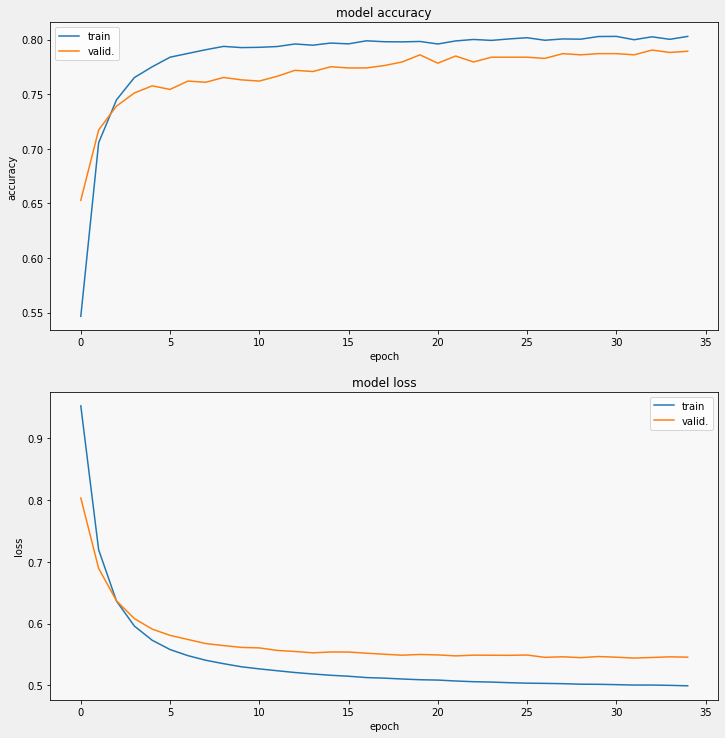

In [11]:
display_training_curves(history.history['accuracy'],
                        history.history['val_accuracy'],
                        'accuracy',
                        211)

display_training_curves(history.history['loss'],
                        history.history['val_loss'],
                        'loss',
                        212)

## Evaluate the model

In [12]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print('%s: %.3f'.format(name, value))

4/4 - 0s - loss: 0.5370 - accuracy: 0.7859
%s: %.3f
%s: %.3f


In [15]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [label2str(x) for x in model.predict_classes(prediction_texts)]

pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background
